In [1]:
from utils.data_acquisition import get_players, get_matches, get_players_perfomance, get_next_match

## Generating player list ranked by position

In [2]:
players = get_players()

In [3]:
positions = players['position'].unique()

In [4]:
players_ranked = players.copy() 
players_ranked['rank'] = None

for position in positions:
    rank = players_ranked[players_ranked['position'] == position].id.rank(method='min')
    rank = rank - 1
    players_ranked.iloc[rank.index,-1] = rank

columns_sorted = ["rank", "nickname", "id", "position", "price", "team", "status"]
players_ranked = players_ranked[columns_sorted].drop_duplicates().sort_values('rank', ignore_index=True)

In [5]:
players_ranked.head(10)

,rank,nickname,id,position,price,team,status
0,0.0,Mano Menezes,37281,tec,8.48,FLU,Nulo
1,0.0,Rafinha,38144,lat,6.31,SAO,Nulo
2,0.0,Hulk,39148,ata,13.85,CAM,Provável
3,0.0,Fábio,37656,gol,7.99,FLU,Nulo
4,0.0,Renato Augusto,38398,mei,4.85,FLU,Nulo
5,0.0,Thiago Silva,37715,zag,10.00,FLU,Nulo
6,1.0,Cássio,42234,gol,11.40,CRU,Nulo
7,1.0,Vagner Mancini,39850,tec,7.62,ACG,Provável
8,1.0,Osvaldo,42222,ata,4.29,VIT,Dúvida
9,1.0,Marcelo,38402,lat,9.64,FLU,Nulo


## Matches

In [6]:
matches = get_matches()

In [7]:
matches["home_score_norm"] = matches["home_score"]/matches["home_score"].max()
matches["away_score_norm"] = matches["away_score"]/matches["away_score"].max()

In [8]:
matches.shape

(160, 8)

In [9]:
matches.head()

,date,home_team,away_team,home_score,away_score,round,home_score_norm,away_score_norm
0,2024-04-13 18:30:00,INT,BAH,2.0,1.0,1,0.4,0.166667
1,2024-04-13 18:30:00,CRI,JUV,1.0,1.0,1,0.2,0.166667
2,2024-04-13 21:00:00,FLU,BGT,2.0,2.0,1,0.4,0.333333
3,2024-04-13 21:00:00,SAO,FOR,1.0,2.0,1,0.2,0.333333
4,2024-04-14 16:00:00,VAS,GRE,2.0,1.0,1,0.4,0.166667


In [10]:
matches.iloc[-1]

date               2024-07-11 21:30:00
home_team                          VIT
away_team                          BOT
home_score                         0.0
away_score                         1.0
round                               16
home_score_norm                    0.0
away_score_norm               0.166667
Name: 159, dtype: object

Remark: RS teams didn't player last rounds

In [11]:
matches = matches.dropna().reset_index()

In [12]:
matches.shape

(153, 9)

### Players performance

In [13]:
players_performance = get_players_perfomance()

In [14]:
players_performance = players_performance.drop(
    ["price", "nickname", "position", "team"], axis=1)

In [15]:
players_performance.head()

,id,points,round
0,100079,2.6,1
1,100084,1.4,1
2,100085,5.0,1
3,100652,1.3,1
4,100846,-1.5,1


Joining the above table with the players table, which contains the ranks

In [16]:
players_performance = players_performance.set_index("id").join(players_ranked.set_index("id"))

In [17]:
players_performance.head()

,points,round,rank,nickname,position,price,team,status
id,,,,,,,,
100079,2.6,1,102.0,Zaracho,mei,7.55,CAM,Nulo
100084,1.4,1,103.0,Igor Gomes,mei,5.22,CAM,Nulo
100085,5.0,1,104.0,Pedro Augusto,mei,4.30,FOR,Provável
100652,1.3,1,71.0,Yuri Alberto,ata,6.93,COR,Provável
100846,-1.5,1,49.0,Lucas Esteves,lat,3.87,VIT,Provável


**Remark**: The price column here can lead to confusion. This price was get from the market database. So, it is the current price of the player in the market.
For this reason, I will rename the column: 

In [18]:
players_performance = players_performance.rename(columns={"price": "current_price"})

In [19]:
players_performance.columns

Index(['points', 'round', 'rank', 'nickname', 'position', 'current_price',
       'team', 'status'],
      dtype='object')

In [20]:
players_performance.shape

(4904, 8)

Removing player that are not available in the market

In [21]:
players_performance.drop(
    players_performance[players_performance['rank'].isnull()].index,
    inplace=True)

players_performance['rank'] = players_performance['rank'].astype(int)

In [22]:
players_performance.head()

,points,round,rank,nickname,position,current_price,team,status
id,,,,,,,,
100079,2.6,1,102,Zaracho,mei,7.55,CAM,Nulo
100084,1.4,1,103,Igor Gomes,mei,5.22,CAM,Nulo
100085,5.0,1,104,Pedro Augusto,mei,4.30,FOR,Provável
100652,1.3,1,71,Yuri Alberto,ata,6.93,COR,Provável
100846,-1.5,1,49,Lucas Esteves,lat,3.87,VIT,Provável


In [23]:
players_performance.shape

(4824, 8)

## Transition matrix M between the states
Until here, it is not clear for me yet what the states in this matrix means

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from typing import Literal, Callable, Tuple
from numpy._typing import NDArray, ArrayLike

In [25]:
def normalize_transition_matrix(m: NDArray) -> NDArray:
    """."""
    M_norm = m.copy()
    M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.
    M_norm = np.nan_to_num(M_norm, nan=1/M_norm.shape[0])  # Replacing no info rows with equally distributed probability
    return M_norm

In [26]:
def forward(home_goals: int, away_goals: int) -> Tuple[int, int]:
    return home_goals, away_goals

def defender(home_goals: int, away_goals: int):
    home_extra_score, away_extra_score = 1, 1
    if away_goals:
        home_extra_score =- 1
    if home_goals:
        away_extra_score = -1
    return home_extra_score, away_extra_score

def midfilder(home_goals: int, away_goals: int) -> Tuple[int, int]:
    forward_h, forward_a = forward(home_goals, away_goals)
    defender_h, defender_a = defender(home_goals, away_goals)
    return forward_h + defender_h, forward_a + defender_a

def manager(*args) -> Tuple[int, int]:
    return 0,0

In [27]:
def generate_m_matrix(
        position: Literal["ata", "mei", "zag", "tec"], 
        extra_function: Callable[[int, int], Tuple[int, int]]
) -> NDArray:
    """."""
    players_performance_position = players_performance[
        players_performance["position"] == position
        ].copy()

    n_players = len(players_ranked[players_ranked["position"] == position])
    M = np.zeros([n_players, n_players])

    # The match are labeled from 0 to len(matches)
    for match in range(len(matches)):
        # Selecting all players that played in the round where the match ocurred
        df_round = players_performance_position[
            players_performance_position["round"] == matches["round"][match]
        ]
        # Selecting the players that played in the given match
        players_home = df_round[df_round["team"] == matches["home_team"][match]]
        players_away = df_round[df_round["team"] == matches["away_team"][match]]

        for p_home in range(len(players_home)):
            for p_away in range(len(players_away)):
                score_home, score_away = 0,0
            
                points_p_home = players_home["points"].iloc[p_home]
                points_p_away = players_away["points"].iloc[p_away]

                sum = points_p_home + points_p_away
                if sum != 0:
                    score_home = points_p_home/sum
                    score_away = points_p_away/sum
                
                # Selecting the coordinates of each player in the matrix
                p1 = players_home["rank"].iloc[p_home]
                p2 = players_away["rank"].iloc[p_away]

                home_extra_score, away_extra_score = extra_function(
                    matches['home_score_norm'][match],
                    matches['away_score_norm'][match]
                )
                home_extra_score, away_extra_score = 0,0

                M[p1,p1] = M[p1,p1] + home_extra_score + score_home
                M[p1,p2] = M[p1,p2] + away_extra_score + score_away
                M[p2,p1] = M[p2,p1] + home_extra_score + score_home
                M[p2,p2] = M[p2,p2] + away_extra_score + score_away
    
    # return normalize_transition_matrix(M)
    return M


In [28]:
def stacionary_distribution(m_norm: NDArray) -> ArrayLike:
    """."""
    tolerances = [1e-10, 1e-4, 1e-3, 1e-2]
    evals, evecs = np.linalg.eig(m_norm.T)
    
    for tol in tolerances:
        try: # TODO: Change this to a size validation
            # evec1 = evecs[:,np.isclose(evals, 1, rtol=0, atol=tol)] # Increase the tolerance a little
            evec1 = evecs[:,np.isclose(evals, 1, rtol=0, atol=tol)] # Increase the tolerance a little
            evec1 = evec1[:,0]
        except:
            print(f"tolerance: {tol} didn't work")
            continue
        stationary = evec1 / evec1.sum()
        stationary = stationary.real
        return stationary, evals, evecs

In [29]:
out_data = {
    "gol": {"func": defender},
    "zag": {"func": defender},
    "lat": {"func": defender},
    "mei": {"func": midfilder},
    "ata": {"func": forward},
    "tec": {"func": manager}
}

In [30]:
for position, content in out_data.items():
    content['M'] = generate_m_matrix(position, content["func"])
    content['M_norm'] = normalize_transition_matrix(content['M'])
    content["st_dist"], *_ = stacionary_distribution(content['M_norm'])

/tmp/ipykernel_1912/3863926212.py:4: RuntimeWarning: invalid value encountered in divide
  M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.


Transiction matrix plot

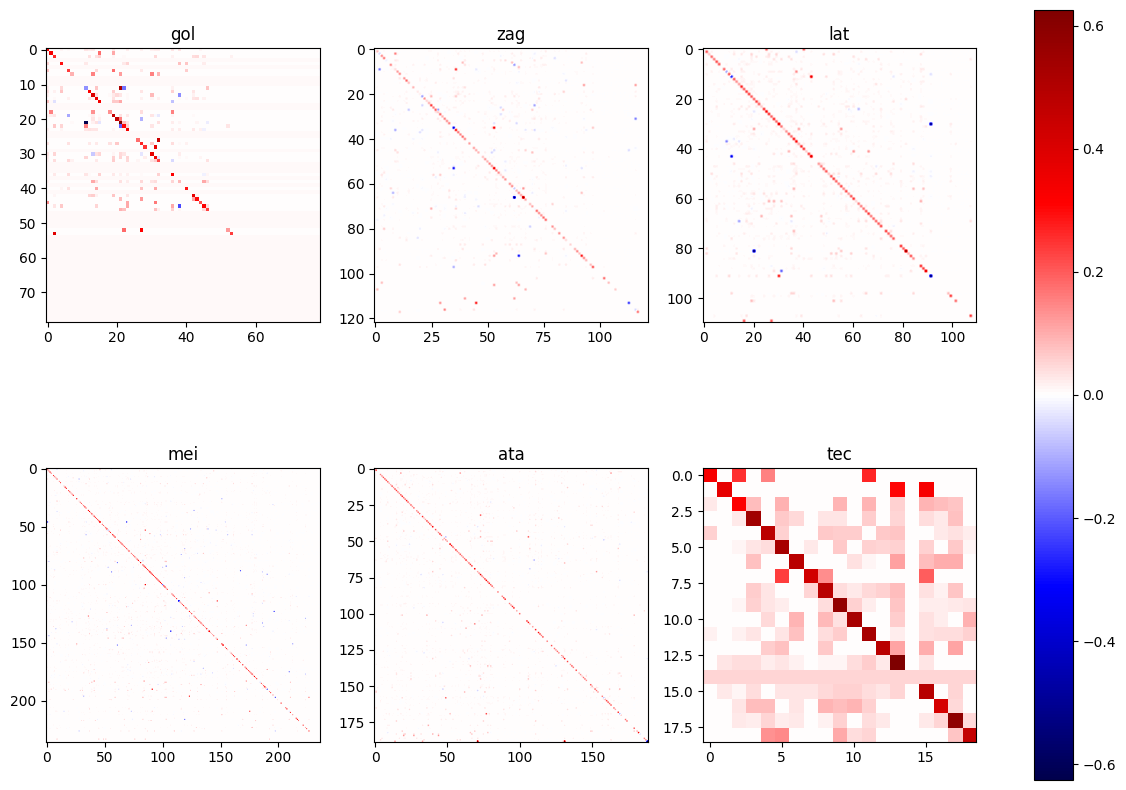

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].imshow(out_data[key]["M_norm"], cmap='seismic', norm=TwoSlopeNorm(0))
    axesli[i].set_title(key)

fig.colorbar(im, ax=axes.ravel())


Stationary Distribution plot 

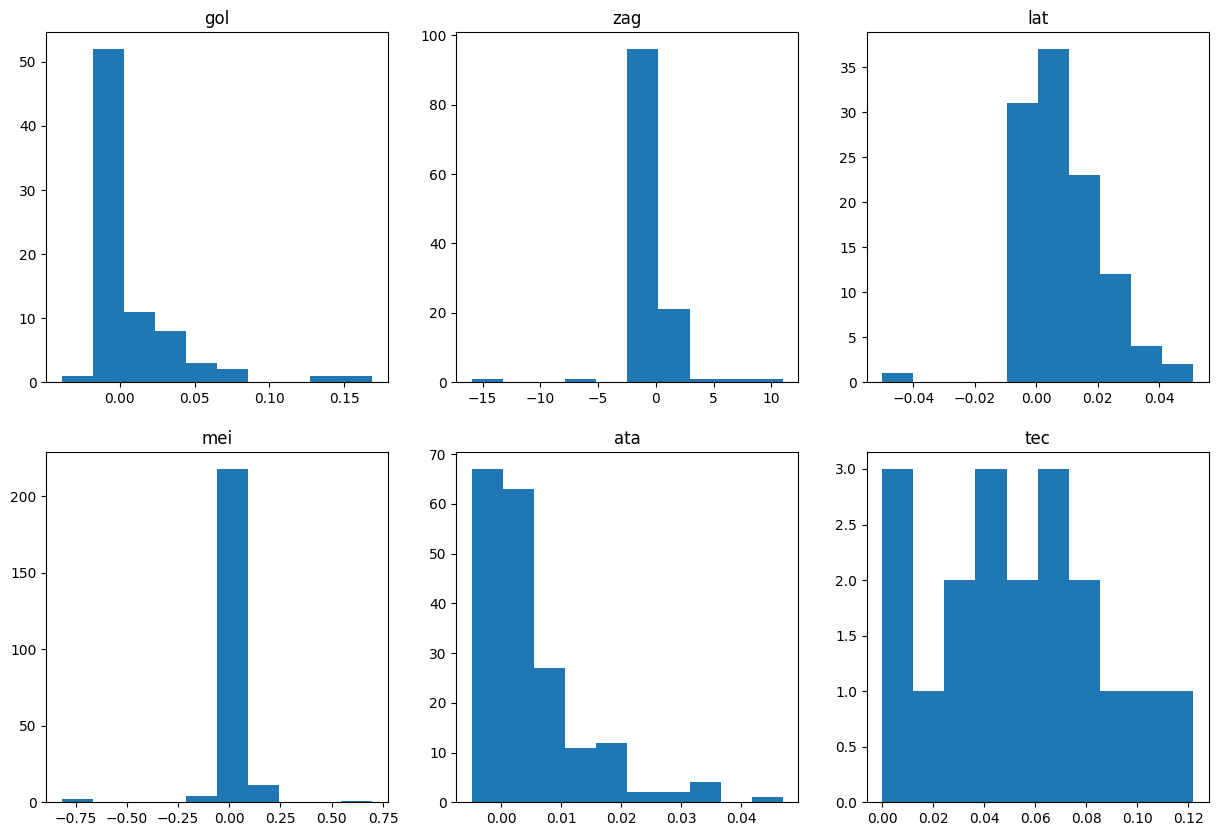

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].hist(out_data[key]["st_dist"])
    axesli[i].set_title(key)

### Overperfomance players for each position

In [33]:
position = 'gol'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
3,0.0,Fábio,37656,gol,7.99,FLU,Nulo
13,2.0,Walter,51413,gol,6.22,CUI,Nulo
75,12.0,Marchesín,70332,gol,5.67,GRE,Provável
82,13.0,Gabriel,70449,gol,5.23,JUV,Provável
84,14.0,Weverton,71631,gol,10.53,PAL,Provável


In [34]:
position = 'zag'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)]

,rank,nickname,id,position,price,team,status
54,9.0,Pedro Henrique,71038,zag,4.40,ACG,Contundido
147,25.0,Léo Pereira,83528,zag,5.95,FLA,Nulo
476,94.0,Rômulo,115268,zag,2.28,CAM,Nulo
489,97.0,Robert Renan,117330,zag,7.44,INT,Nulo


In [35]:
position = 'lat'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > 0)].head()

,rank,nickname,id,position,price,team,status
9,1.0,Marcelo,38402,lat,9.64,FLU,Nulo
14,2.0,Mariano,38877,lat,4.18,CAM,Nulo
18,3.0,Fagner,42500,lat,6.97,COR,Nulo
26,4.0,Cicinho,61106,lat,4.17,BAH,Nulo
33,5.0,Marcos Rocha,63013,lat,7.41,PAL,Nulo


In [36]:
position = 'mei'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
16,2.0,Alan Franco,39656,mei,3.61,CAM,Provável
56,9.0,Eduardo,68708,mei,6.26,BOT,Contundido
114,19.0,Bruno Henrique,70944,mei,5.45,INT,Nulo
184,33.0,Jadson,80129,mei,9.81,JUV,Provável
216,39.0,Otávio,82463,mei,6.30,CAM,Provável


In [37]:
position = 'ata'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
2,0.0,Hulk,39148,ata,13.85,CAM,Provável
8,1.0,Osvaldo,42222,ata,4.29,VIT,Dúvida
57,9.0,Pablo,69138,ata,5.84,CAP,Nulo
92,15.0,Everaldo,78117,ata,8.14,BAH,Nulo
116,19.0,Luciano,80287,ata,10.91,SAO,Provável


In [38]:
position = 'tec'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
19,3.0,Tite,45125,tec,10.42,FLA,Nulo
25,4.0,Cláudio Tencati,78450,tec,6.32,CRI,Provável
35,5.0,Roger Machado,79437,tec,7.98,JUV,Provável
38,6.0,Petit,89141,tec,6.35,CUI,Nulo
51,8.0,Gabriel Milito,96673,tec,8.88,CAM,Provável


## Using linear programming to build the team

Adding probabilities in players on the market data

In [39]:
df_players_anl = players_ranked.copy()
df_players_anl['rank'] = df_players_anl['rank'].astype(int)
df_players_anl['prob'] = 0.00

In [40]:
def get_prob(df):
    position = df['position']
    rank = df['rank']
    return out_data.get(position)["st_dist"][int(rank)]

In [41]:
df_players_anl['prob'] = df_players_anl.apply(get_prob, axis=1)

In [42]:
df_players_anl.sort_values('prob', ascending=False).head()

,rank,nickname,id,position,price,team,status,prob
147,25,Léo Pereira,83528,zag,5.95,FLA,Nulo,10.989701
489,97,Robert Renan,117330,zag,7.44,INT,Nulo,7.724417
54,9,Pedro Henrique,71038,zag,4.40,ACG,Contundido,4.381443
476,94,Rômulo,115268,zag,2.28,CAM,Nulo,2.182513
166,29,Rodrigo,86684,zag,4.64,CRI,Provável,2.001326


Lets remove probs that aren't between -1 and 1.

In [43]:
df_players_anl = df_players_anl[(df_players_anl['prob'] > -1) & (df_players_anl['prob'] < 1)]

In [44]:
df_players_anl['nickname'] = df_players_anl['nickname'].str.replace(" ", "_")
df_players_likely = df_players_anl[df_players_anl.status == "Provável"]

### Giving extra probability points for the players that will play at home.

I found this [study](https://www.scielo.br/j/rbcdh/a/wc9c38CkYs5NZJYSF6SpNJR/?format=pdf&lang=pt) who says that teams in brazillian championship has 25% more chance to win when playing at home;


In [45]:
next_matches = get_next_match()

In [46]:
home_team = next_matches["home_team"].values

In [47]:
home_team

array(['INT', 'FLU', 'CRU', 'BAH', 'JUV', 'COR', 'ACG', 'SAO', 'BOT',
       'FOR'], dtype=object)

In [48]:
df_players_likely_bonus = df_players_likely.copy()

In [49]:
df_players_likely_bonus.loc[df_players_likely_bonus.team.isin(home_team), 'prob'] *= 1.25

In [50]:
df_players_likely_bonus.head()

,rank,nickname,id,position,price,team,status,prob
2,0,Hulk,39148,ata,13.85,CAM,Provável,0.011101
7,1,Vagner_Mancini,39850,tec,7.62,ACG,Provável,0.011753
16,2,Alan_Franco,39656,mei,3.61,CAM,Provável,0.137493
17,2,Renato_Gaúcho,41929,tec,7.94,GRE,Provável,0.025609
23,3,Titi,50353,zag,4.55,FOR,Provável,-0.530379


### Optimization

In [51]:
from pulp import LpMaximize, LpProblem, lpSum, LpVariable
from itertools import product as  cartersian_product
import pandas as pd

In [52]:
# Team and money constraints
team = {
    'ata': 3,
    'mei': 3,
    'lat': 2,
    'zag': 2,
    'gol':1,
    'tec':1
}

money = 106.76

In [53]:
# Selecting the dataframe to use in the optimization
df = df_players_likely_bonus.copy()

In [54]:
df.set_index("id", inplace=True)
df.head()

,rank,nickname,position,price,team,status,prob
id,,,,,,,
39148,0,Hulk,ata,13.85,CAM,Provável,0.011101
39850,1,Vagner_Mancini,tec,7.62,ACG,Provável,0.011753
39656,2,Alan_Franco,mei,3.61,CAM,Provável,0.137493
41929,2,Renato_Gaúcho,tec,7.94,GRE,Provável,0.025609
50353,3,Titi,zag,4.55,FOR,Provável,-0.530379


In [55]:
sorted = df.sort_values(by=['prob'], axis=0, ascending=False)
sorted[sorted.position == "ata"]

,rank,nickname,position,price,team,status,prob
id,,,,,,,
101002,73,Júnior_Santos,ata,8.23,BOT,Provável,0.040508
112886,113,Lucas_Barbosa,ata,8.90,JUV,Provável,0.035906
91607,45,Rony,ata,7.03,PAL,Provável,0.034005
128915,168,Estêvão,ata,7.96,PAL,Provável,0.028158
80287,19,Luciano,ata,10.91,SAO,Provável,0.024175
99818,69,Paulinho,ata,13.16,CAM,Provável,0.022350
88323,33,Ángel_Romero,ata,5.45,COR,Provável,0.020539
99198,67,Vegetti,ata,12.74,VAS,Provável,0.020518
105568,89,Lucero,ata,10.79,FOR,Provável,0.019847


In [56]:
all_conflicts = []
# Computing all combinations of players that will  play against
for _, row in next_matches.iterrows(): # We just have 9 lines, it is not too bad use iterrows here
    home_team, away_team = row['home_team'], row['away_team']
    players_home = df[df['team'] == home_team].index.values
    players_away = df[df['team'] == away_team].index.values
    all_conflicts += list(cartersian_product(players_home, players_away))

In [57]:
len(all_conflicts)

650

In [58]:
z = df['prob'].to_dict()
c = df['price'].to_dict()

dummies_position = pd.get_dummies(df.position)
dummies_position = dummies_position.to_dict()
prob = LpProblem("Players CHoice", LpMaximize)
y = LpVariable.dicts("player_id", df.index , 0,1, cat='Binary')
prob += lpSum([z[i] * y[i] for i in y])

/home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [59]:
prob += lpSum([c[i] * y[i] for i in y]) <= money, "money_limit"
prob += lpSum([dummies_position['ata'][i] * y[i] for i in y]) == team['ata'], "Quantidade Atacantes"
prob += lpSum([dummies_position['lat'][i] * y[i] for i in y]) == team['lat'], "Quantidade Laterais"
prob += lpSum([dummies_position['mei'][i] * y[i] for i in y]) == team['mei'], "Quantidade Meio"
prob += lpSum([dummies_position['zag'][i] * y[i] for i in y]) == team['zag'], "Quantidade Zagueiros"
prob += lpSum([dummies_position['gol'][i] * y[i] for i in y]) == team['gol'], "Quantidade Gol"
prob += lpSum([dummies_position['tec'][i] * y[i] for i in y]) == team['tec'], "Quantidade Tecnico"

# Add the conflicts rule
for i, j in all_conflicts:
    prob += y[i] + y[j] <= 1

In [60]:
money

106.76

In [61]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8078ed03c9e74b80894926aafba4cdff-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8078ed03c9e74b80894926aafba4cdff-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 662 COLUMNS
At line 2588 RHS
At line 3246 BOUNDS
At line 3372 ENDATA
Problem MODEL has 657 rows, 125 columns and 1550 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.81056 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substit

1

In [62]:
escalados = []
for v in prob.variables():
    if v.varValue == 1:
        atleta = v.name.replace('player_id_','')
        escalados.append(int(atleta))
        print(atleta, "=", v.varValue)

101002 = 1.0
104085 = 1.0
104994 = 1.0
127273 = 1.0
39656 = 1.0
80287 = 1.0
82463 = 1.0
87008 = 1.0
87999 = 1.0
95466 = 1.0
97522 = 1.0
99818 = 1.0


In [63]:
my_team = df.loc[escalados]

In [64]:
my_team

,rank,nickname,position,price,team,status,prob
id,,,,,,,
101002,73,Júnior_Santos,ata,8.23,BOT,Provável,0.040508
104085,69,Bruno_Fuchs,zag,4.44,CAM,Provável,0.186443
104994,73,Wagner_Leonardo,zag,5.01,VIT,Provável,0.784308
127273,17,Artur_Jorge,tec,9.00,BOT,Provável,0.123699
39656,2,Alan_Franco,mei,3.61,CAM,Provável,0.137493
80287,19,Luciano,ata,10.91,SAO,Provável,0.024175
82463,39,Otávio,mei,6.30,CAM,Provável,0.123841
87008,23,Léo_Jardim,gol,7.13,VAS,Provável,0.071244
87999,59,Gustavo_Scarpa,mei,11.57,CAM,Provável,0.192920


In [65]:
my_team['price'].sum()

91.16999999999999

In [66]:
# Captain
my_team[my_team['position'].isin(["ata", "mei"])].sort_values('prob', axis=0, ascending=False)

,rank,nickname,position,price,team,status,prob
id,,,,,,,
87999,59,Gustavo_Scarpa,mei,11.57,CAM,Provável,0.192920
39656,2,Alan_Franco,mei,3.61,CAM,Provável,0.137493
82463,39,Otávio,mei,6.30,CAM,Provável,0.123841
101002,73,Júnior_Santos,ata,8.23,BOT,Provável,0.040508
80287,19,Luciano,ata,10.91,SAO,Provável,0.024175
99818,69,Paulinho,ata,13.16,CAM,Provável,0.022350


TODO: 
- ~~Adicionar bonus para o caso do próximo jogo ser em casa;~~
- Adicionar bonus para quem joga contra os últimos da tabela; ou a diferença entre as posições(?)
- ~~Adicionar restrição para que os jogadores escalados não se enfrentem na rodada;~~
- Adicionar minimização para escolher os melhores reservas;
- Adicionar possibilidade de outras escalações;
- ~~Adicionar método para a escolha do capitão.~~



## Model Results

In [67]:
results = pd.read_csv("results/2024.csv")

In [68]:
results.columns

Index(['Rodada', 'Score', 'Players Mean', 'Money', 'Aditional Info'], dtype='object')

<Axes: title={'center': 'Model Results'}, xlabel='Rodada'>

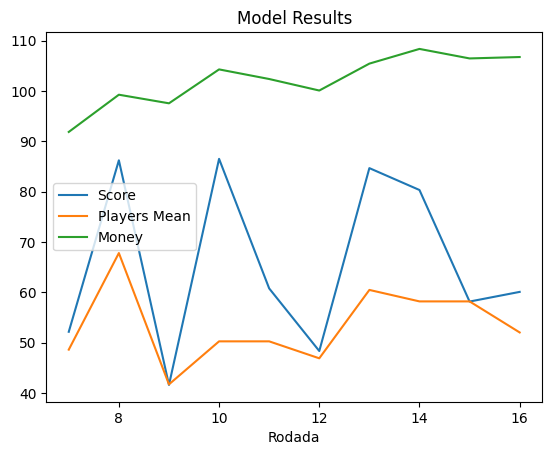

In [69]:
results.plot(x='Rodada', y=['Score', 'Players Mean', "Money"], title='Model Results')